# Fernando's code, messing around, clean code is later

In [1]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, EvenProcess, GoldenMean, Mess3, RIP, TransitionMatrixProcess, ZeroOneR
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.comp_mech.reversal import reverse_process, get_recurrent_component_process_from_mstree, get_prob_forward_given_past, joint_prob_from_conditional
from epsilon_transformers.comp_mech.reversal import joint_prob_from_conditional
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
from typing import Dict, Tuple
from tqdm.auto import tqdm

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from transformer_lens import HookedTransformer, HookedTransformerConfig
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader

In [2]:
T_even = np.array([
    [[0.0, 0.5],
     [1.0, 0.0]],

    [[0.5, 0.0],
     [0.0, 0.0]]
])

T_golden = np.array([
    [[0.5, 0.0],
     [1.0, 0.0]],
     
    [[0.0, 0.5],
     [0.0, 0.0]]
])

even = TransitionMatrixProcess(T_even)
golden = TransitionMatrixProcess(T_golden)

def combine_hmms_einsum(T1, T2):
    T_combined = np.einsum('ijk,lmn->iljmkn', T1, T2)
    M1, N1, _ = T1.shape
    M2, N2, _ = T2.shape
    return T_combined.reshape(M1*M2, N1*N2, N1*N2)

T = combine_hmms_einsum(golden.transition_matrix, even.transition_matrix)

final_process = TransitionMatrixProcess(T)

In [3]:
final_process.transition_matrix

array([[[0.  , 0.25, 0.  , 0.  ],
        [0.5 , 0.  , 0.  , 0.  ],
        [0.  , 0.5 , 0.  , 0.  ],
        [1.  , 0.  , 0.  , 0.  ]],

       [[0.25, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.5 , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , 0.25],
        [0.  , 0.  , 0.5 , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.25, 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  ]]])

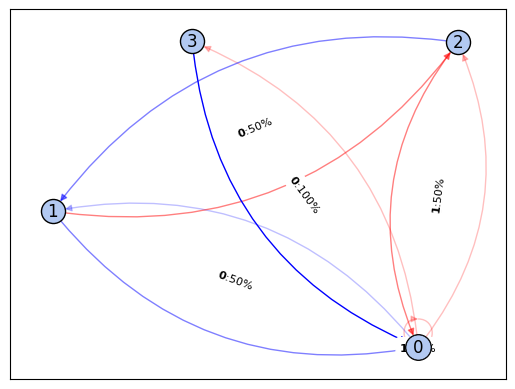

In [4]:
# visualize final frocess
graph = transition_matrix_to_graph(final_process.transition_matrix)
visualize_graph(graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)

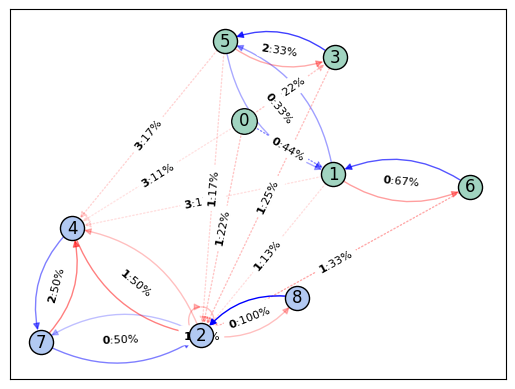

In [5]:
msp = final_process.derive_mixed_state_tree(depth=10)
msp_transition, _ = msp.build_msp_transition_matrix()
msp_process = TransitionMatrixProcess(msp_transition)
msp_process_graph = transition_matrix_to_graph(msp_process.transition_matrix)
visualize_graph(msp_process_graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)
paths, beliefs = msp.paths_and_belief_states

In [6]:
# visualize the beliefs in 3d
beliefs = np.array(beliefs)
fig = px.scatter_3d(x=beliefs[:,0], y=beliefs[:,1], z=beliefs[:,2], opacity=0.7)
fig.show()

In [7]:
final_msp_process = TransitionMatrixProcess(final_process.transition_matrix)
graph = transition_matrix_to_graph(final_msp_process.transition_matrix)

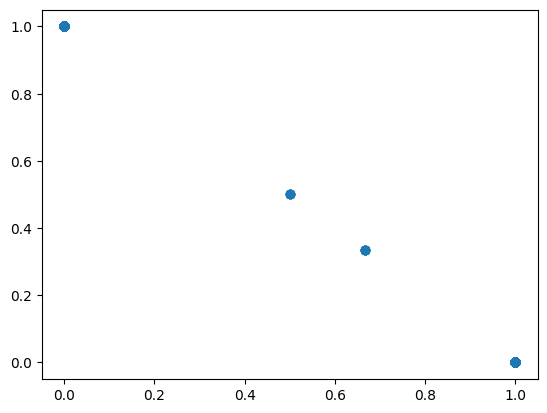

In [8]:
golden_msp = golden.derive_mixed_state_tree(depth=10)
golden_paths, golden_beliefs = golden_msp.paths_and_belief_states

even_msp = even.derive_mixed_state_tree(depth=10)
even_paths, even_beliefs = even_msp.paths_and_belief_states

even_beliefs = np.array(even_beliefs)

plt.scatter(even_beliefs[:,0],even_beliefs[:,1])

golden_beliefs = np.array(golden_beliefs)
#plt.scatter(golden_beliefs[:,0],golden_beliefs[:,1])

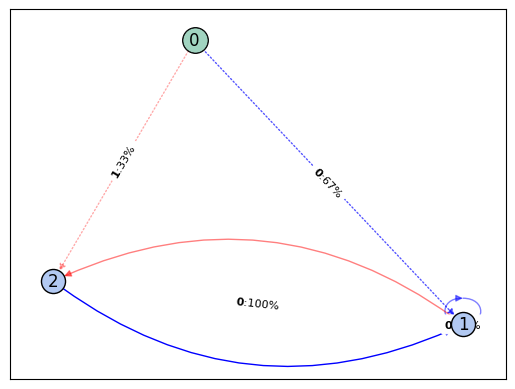

In [9]:
even_process = GoldenMean(R=1)
msp_even = even_process.derive_mixed_state_tree(depth=10)
msp_transition, _ = msp_even.build_msp_transition_matrix()
msp_process = TransitionMatrixProcess(msp_transition)
msp_process_graph = transition_matrix_to_graph(msp_process.transition_matrix)
visualize_graph(msp_process_graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)

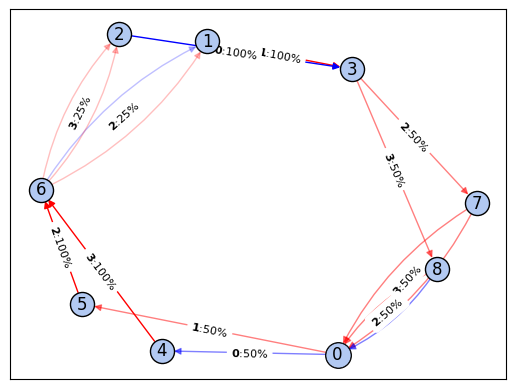

[[0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0. ]]


In [10]:
random_not_T = np.zeros((2,3,3))
random_not_T[0,0,1] = 0.5
random_not_T[0,2,0] = 1.0
random_not_T[1,0,2] = 0.5
random_not_T[1,1,0] = 1.0

zero_one_random = ZeroOneR()

combined_process = combine_hmms_einsum(zero_one_random.transition_matrix, random_not_T)
combined_process = TransitionMatrixProcess(combined_process)
combined_process_graph = transition_matrix_to_graph(combined_process.transition_matrix)
visualize_graph(combined_process_graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)

print(combined_process.transition_matrix.sum(axis=0))


# Actual Clean Code

## Define the combined process, golden mean union even

In [11]:
T_even = np.array([
    [[0.0, 0.5],
     [1.0, 0.0]],

    [[0.5, 0.0],
     [0.0, 0.0]]
])

T_golden = np.array([
    [[0.5, 0.0],
     [1.0, 0.0]],
     
    [[0.0, 0.5],
     [0.0, 0.0]]
])

even_process = TransitionMatrixProcess(T_even)
golden_process = TransitionMatrixProcess(T_golden)

def combine_hmms_einsum(T1, T2):
    T_combined = np.einsum('ijk,lmn->iljmkn', T1, T2)
    M1, N1, _ = T1.shape
    M2, N2, _ = T2.shape
    return T_combined.reshape(M1*M2, N1*N2, N1*N2)

T = combine_hmms_einsum(golden_process.transition_matrix, even_process.transition_matrix)

final_process = TransitionMatrixProcess(T)

## visualize the combined process

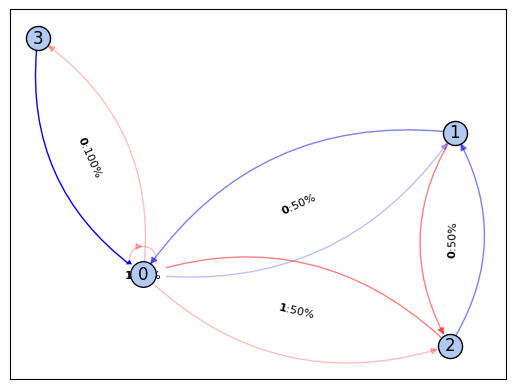

In [12]:
# visualize final frocess
graph = transition_matrix_to_graph(final_process.transition_matrix)
visualize_graph(graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)

## compute and visualize msp for combined process

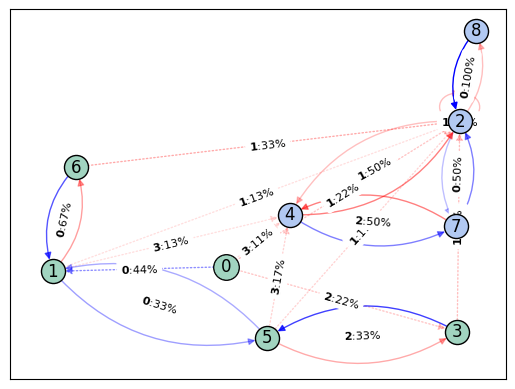

myopic_entropy_rate: [1.27302834 1.06803728 1.01140426 0.99611676 0.96780025 0.9601565
 0.94599825 0.94217637 0.93509724 0.93318631]


In [13]:
msp = final_process.derive_mixed_state_tree(depth=11)
msp_transition, _ = msp.build_msp_transition_matrix()
msp_process = TransitionMatrixProcess(msp_transition)
msp_process_graph = transition_matrix_to_graph(msp_process.transition_matrix)
visualize_graph(msp_process_graph, draw_mixed_state=True, draw_edge_labels=True, draw_color=True)
tree_paths, tree_beliefs = msp.paths_and_belief_states

myopic_entropy_rate = msp.myopic_entropy
minimum_cross_entropy = myopic_entropy_rate
print(f"myopic_entropy_rate: {myopic_entropy_rate}")


In [14]:
# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

# now lets index each belief
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")



Path: , Belief: [0.44444444 0.22222222 0.22222222 0.11111111]
Path: , Belief: [0.44444444 0.22222222 0.22222222 0.11111111]
Path: 3, Belief: [0. 0. 1. 0.]
Path: 31, Belief: [1. 0. 0. 0.]
Path: 313, Belief: [0. 0. 1. 0.]
Number of Unique beliefs: 9 out of 141521
(0.0, 0.0, 0.0, 1.0) is indexed as 0
(0.0, 0.0, 1.0, 0.0) is indexed as 1
(0.0, 0.0, 0.5, 0.5) is indexed as 2
(0.0, 1.0, 0.0, 0.0) is indexed as 3
(0.66667, 0.33333, 0.0, 0.0) is indexed as 4


## Set up Training Data

In [15]:
train_config = {
    'seed': 42,
    'n_ctx': 8,
    'act_fn': 'relu',
    'd_head': 16,
    'd_model': 32,
    'd_vocab': 4,
    'd_mlp': 32*4,
    'n_heads': 2,
    'n_layers': 2,
    'attn_only': False,
    'optimizer': 'adamw', # or sgd or adam
    'batch_size': 500,
    'num_epochs': 500,
    'weight_decay': 0.0,
    'attention_dir': 'causal',
    'learning_rate': 3e-5,
    'normalization_type': 'LN',
    'fixed_train_dataset': False,
    'num_train_samples': 10000,
    'fixed_valid_dataset': True,
    'num_valid_samples': 2000,
}
print("\n".join(f"{k}: {v}" for k, v in train_config.items()))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

seed: 42
n_ctx: 8
act_fn: relu
d_head: 16
d_model: 32
d_vocab: 4
d_mlp: 128
n_heads: 2
n_layers: 2
attn_only: False
optimizer: adamw
batch_size: 500
num_epochs: 500
weight_decay: 0.0
attention_dir: causal
learning_rate: 3e-05
normalization_type: LN
fixed_train_dataset: False
num_train_samples: 10000
fixed_valid_dataset: True
num_valid_samples: 2000
Using device: cpu


In [16]:
# now lets set up all the inputs as they arrive into the transformer
transformer_inputs = [x for x in tree_paths if len(x) == train_config["n_ctx"]]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])
print(transformer_inputs.shape)

# The following function is the one that is used to get the beliefs for the transformer inputs
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs,
                                                                                                 msp_belief_index,
                                                                                                 tree_paths,
                                                                                                 tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")

tensor([[3, 1, 3, 1, 3, 1, 3, 1],
        [3, 1, 3, 1, 3, 1, 3, 0],
        [3, 1, 3, 1, 3, 1, 2, 0],
        [3, 1, 3, 1, 3, 1, 1, 3],
        [3, 1, 3, 1, 3, 1, 1, 2]], dtype=torch.int32)
torch.Size([4840, 8])
Transformer Input Beliefs: torch.Size([4840, 8, 4]), Transformer Input Belief Indices: torch.Size([4840, 8])


In [17]:
# instantiate pytorch transformer model using our config

config = HookedTransformerConfig(
    d_model=train_config['d_model'],
    d_head=train_config['d_head'],
    n_layers=train_config['n_layers'],
    n_ctx=train_config['n_ctx'],
    n_heads=train_config['n_heads'],
    d_mlp=train_config['d_mlp'],
    d_vocab=train_config['d_vocab'],
    seed=train_config['seed'],
    device=device,
    act_fn=train_config['act_fn'],
    attn_only=train_config['attn_only'],
    normalization_type=train_config['normalization_type'],
)
model = HookedTransformer(config)

print(model)
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)
        print(f"     {p.numel()}, {list(p.shape)}")
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total model parameters: {total_parameters}")

optimizer_dict = {
    'sgd': torch.optim.SGD,
    'adam': torch.optim.Adam,
    'adamw': torch.optim.AdamW,
}
optim = optimizer_dict[train_config['optimizer'].lower()]
optimizer = optim(model.parameters(), lr=train_config['learning_rate'], weight_decay=train_config['weight_decay'])
criterion = nn.CrossEntropyLoss(reduction="none")
#minimum_cross_entropy = torch.tensor(minimum_cross_entropy, dtype=torch.float32).to(device)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

# code for training

In [18]:
def train_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    minimum_cross_entropy: torch.Tensor,
):
    model.train()
    for X, Y_true in train_dataloader:
        X, Y_true = X.to(device), Y_true.to(device)
        optimizer.zero_grad()
        Y = model(X)  # Forward pass
        loss = criterion(Y.view(-1, model.cfg.d_vocab), Y_true.view(-1))
        loss = loss.view(X.shape[0], X.shape[1])  # *(batch_size, n_ctx)
        mean_loss, relative_loss = compute_losses(loss, minimum_cross_entropy)
        mean_loss.backward()
        optimizer.step()
        log_data = {
            "loss": mean_loss.item(),
            "relative_loss": relative_loss.mean().item(),
        }
        for i, rel_loss in enumerate(relative_loss):
            log_data[f"relative_loss_{i}"] = rel_loss.item()

    # validation
    model.eval()
    with torch.no_grad():
      for X, Y_true in valid_dataloader:
          X, Y_true = X.to(device), Y_true.to(device)
          Y = model(X)
          loss = criterion(Y.view(-1, model.cfg.d_vocab), Y_true.view(-1))
          loss = loss.view(X.shape[0], X.shape[1])  # *(batch_size, n_ctx)
          mean_loss, relative_loss = compute_losses(loss, minimum_cross_entropy)
          log_data["val_loss"] = mean_loss.item()
          log_data["val_relative_loss"] = relative_loss.mean().item()
          for i, rel_loss in enumerate(relative_loss):
              log_data[f"val_relative_loss_{i}"] = rel_loss.item()

    return log_data


def compute_losses(
    loss: torch.Tensor, minimum_cross_entropy: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    per_position_loss = loss.mean(dim=0)  # *(n_ctx,)
    relative_loss = per_position_loss / minimum_cross_entropy
    mean_loss = per_position_loss.mean()
    return mean_loss, relative_loss

In [19]:
from typing import List, Dict, Optional, Tuple, Iterable

class CustomProcessDataset(IterableDataset):

    def __init__(self, process, sequence_length, num_samples, fixed=False):
        super().__init__()
        self.process = process
        self.sequence_length = sequence_length
        self.num_samples = num_samples
        self.fixed = fixed
        if self.fixed:
          self.samples = list(self._get_samples())
        else:
          self.samples = None

    def _get_samples(self):
      return self.process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self._get_samples() if self.samples is None else iter(self.samples)
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]]):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_dataset = CustomProcessDataset(final_process, sequence_length=train_config['n_ctx'], num_samples=train_config['num_train_samples'],
                                     fixed=train_config['fixed_train_dataset'])
valid_dataset = CustomProcessDataset(final_process, sequence_length=train_config['n_ctx'], num_samples=train_config['num_valid_samples'],
                                     fixed=train_config['fixed_valid_dataset'])
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], collate_fn=process_dataset_collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=train_config['batch_size'], collate_fn=process_dataset_collate_fn)

In [20]:
minimum_loss = torch.tensor(minimum_cross_entropy, dtype=torch.float32).to(device)
print(minimum_loss)

tensor([1.2730, 1.0680, 1.0114, 0.9961, 0.9678, 0.9602, 0.9460, 0.9422, 0.9351,
        0.9332])


In [78]:
for epoch in tqdm(range(1, train_config['num_epochs'] + 1)):
    log_data = train_epoch(model=model,
                           optimizer=optimizer,
                           train_dataloader=train_dataloader,
                           valid_dataloader=valid_dataloader,
                           criterion=criterion,
                           minimum_cross_entropy=minimum_loss[1:config.n_ctx+1])
    print(f"epoch {epoch:>3d}, loss: {log_data['loss']:.06f}, relative loss: {log_data['relative_loss']:.06f}, "
          f"val loss: {log_data['val_loss']:.06f}, val relative loss: {log_data['val_relative_loss']:.06f}")

  0%|          | 0/500 [00:00<?, ?it/s]

epoch   1, loss: 0.977841, relative loss: 0.999718, val loss: 0.981309, val relative loss: 1.003234
epoch   2, loss: 0.978021, relative loss: 0.999552, val loss: 0.980859, val relative loss: 1.002766
epoch   3, loss: 0.980669, relative loss: 1.002570, val loss: 0.980820, val relative loss: 1.002694
epoch   4, loss: 0.989720, relative loss: 1.011491, val loss: 0.980736, val relative loss: 1.002657
epoch   5, loss: 0.984851, relative loss: 1.006664, val loss: 0.980254, val relative loss: 1.002150
epoch   6, loss: 0.985601, relative loss: 1.007462, val loss: 0.980426, val relative loss: 1.002317
epoch   7, loss: 0.975818, relative loss: 0.997618, val loss: 0.981250, val relative loss: 1.003160
epoch   8, loss: 0.983774, relative loss: 1.005202, val loss: 0.980210, val relative loss: 1.002085
epoch   9, loss: 0.982462, relative loss: 1.004580, val loss: 0.981117, val relative loss: 1.002990
epoch  10, loss: 0.982848, relative loss: 1.004698, val loss: 0.981099, val relative loss: 1.002982


In [64]:
# now run all inputs through the model
model.eval()
with torch.no_grad():
  logits = model(transformer_inputs)
  print(logits.shape)
  print(logits.argmax(dim=-1))
  print(transformer_inputs.shape)
  print(transformer_inputs.argmax(dim=-1))


logits, cache = model.run_with_cache(transformer_inputs, names_filter=lambda name: 'resid_post' in name)

torch.Size([4840, 8, 4])
tensor([[1, 3, 1,  ..., 2, 0, 3],
        [1, 3, 1,  ..., 2, 0, 0],
        [1, 3, 1,  ..., 2, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]])
torch.Size([4840, 8])
tensor([0, 0, 0,  ..., 7, 7, 0])


In [65]:
cache

ActivationCache with keys ['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post']

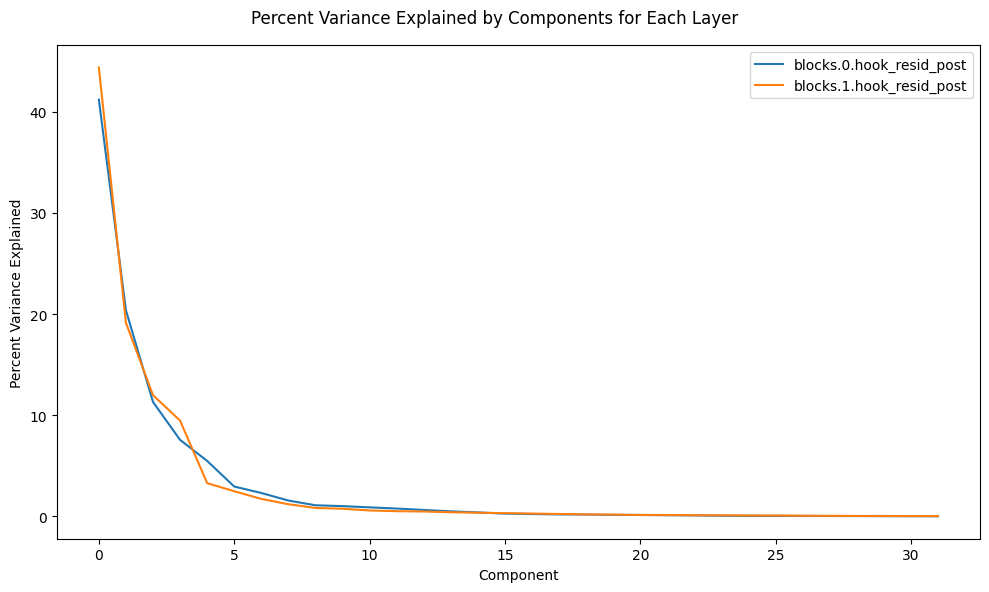

In [66]:
def analyze_activations(acts, layer_name):
    acts = acts.cpu().numpy().reshape(-1, config.d_model)
    U, S, Vt = np.linalg.svd(acts, full_matrices=False)
    percent_variance_explained = (S**2 / (S**2).sum()) * 100  # Corrected calculation
    return percent_variance_explained

# Create a single figure
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Percent Variance Explained by Components for Each Layer')

# Loop through each item in cache
for layer_name, acts in cache.items():
    percent_variance_explained = analyze_activations(acts, layer_name)
    
    # Plot the percent variance explained by each component
    ax.plot(percent_variance_explained, label=layer_name)

ax.set_xlabel('Component')
ax.set_ylabel('Percent Variance Explained')
ax.legend()

plt.tight_layout()
plt.show()

[0.59591707 0.54226265 0.18805105 0.18695909]


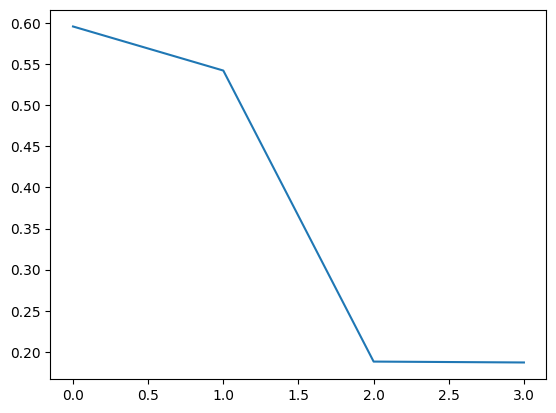

In [67]:
# do svd on the actual belief states
unique_states = np.unique(tree_beliefs, axis=0)
belief_states = np.array(unique_states)
U, S, Vt = np.linalg.svd(belief_states, full_matrices=False)
percent_variance_explained = S**2 / S.sum()
print(percent_variance_explained)

# plot the percent variance explained by each component
plt.plot(percent_variance_explained)
plt.show()

In [68]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions

In [75]:
regression, belief_predictions = run_activation_to_beliefs_regression(cache['blocks.1.hook_resid_post'], transformer_input_beliefs)
belief_dim = transformer_input_beliefs.shape[-1]
activation_flattened = cache['blocks.1.hook_resid_post'].view(-1, config.d_model).cpu().numpy()
ground_truth_beliefs_flattened = transformer_input_beliefs.view(-1, belief_dim).cpu().numpy()
error = regression.score(activation_flattened, ground_truth_beliefs_flattened)
print(error)

0.8896071910858154


In [76]:
belief_predictions.shape

(4840, 8, 4)

In [77]:
import pandas as pd
import plotly.graph_objects as go

# Calculate the center of mass (COM) for each unique belief index
unique_belief_indices = np.unique(transformer_input_belief_indices)
com_data = []
ground_truth_data = []

for index in unique_belief_indices:
    mask = (transformer_input_belief_indices == index).reshape(-1)
    group_predictions = belief_predictions_flattened[mask]
    group_ground_truth = ground_truth_beliefs_flattened[mask]
    com_pred = np.mean(group_predictions, axis=0)
    com_truth = np.mean(group_ground_truth, axis=0)
    com_data.append({
        'x': com_pred[0],
        'y': com_pred[1],
        'z': com_pred[2],
        'belief_index': index
    })
    ground_truth_data.append({
        'x': com_truth[0],
        'y': com_truth[1],
        'z': com_truth[2],
        'belief_index': index
    })

# Create DataFrames from the COM data
com_df = pd.DataFrame(com_data)
ground_truth_df = pd.DataFrame(ground_truth_data)

# Create a 3D scatter plot
fig = go.Figure()

# Add predicted beliefs
fig.add_trace(go.Scatter3d(
    x=com_df['x'],
    y=com_df['y'],
    z=com_df['z'],
    mode='markers',
    marker=dict(
        size=6,  # Reduced size from 8 to 6
        color=com_df['belief_index'],
        colorscale='viridis',
        opacity=0.8
    ),
    text=com_df['belief_index'],
    name='Predicted Beliefs'
))

# Add ground truth beliefs
fig.add_trace(go.Scatter3d(
    x=ground_truth_df['x'],
    y=ground_truth_df['y'],
    z=ground_truth_df['z'],
    mode='markers',
    marker=dict(
        size=2,  # Reduced size from 8 to 6
        color=ground_truth_df['belief_index'],
        colorscale='viridis',
        opacity=0.8,
        symbol='x'
    ),
    text=ground_truth_df['belief_index'],
    name='Ground Truth Beliefs'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    coloraxis_colorbar=dict(title='Belief Index'),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()